# Data Collection

If you just want to access the colorado wildflower dataset, the files have been since been uploaded to Kaggle.com. This notebook showcases the process used to collect the wildflower data. 

## Flower Names

Images of flowers need to be screped off the web to create the dataset. Flower names will be taken from https://uswildflowers.com/wfquery.php?State=CO and Flickr image search will be used to collect 200 images for each flower type. 

reference 
https://www.hindawi.com/journals/wcmc/2020/8870649/#materials-and-methods

In [19]:
# Extract Flower Names
import requests
from bs4 import BeautifulSoup

page = 'utils/US Wildflower\'s Database of Wildflowers for Colorado.html'
with open(page) as fp:
    soup = BeautifulSoup(fp, 'html.parser')

tags = soup.find_all('img', alt=True)
flowers = [tag.get('alt').replace('*', '') for tag in tags]
flowers.sort()

flowers.remove('Follow on Twitter')
flowers.remove('Quantcast')

In [20]:
print(flowers, len(flowers))


['Achillea millefolium', 'Agalinis tenuifolia', 'Allium acuminatum', 'Allium cernuum', 'Ambrosia artemisiifolia', 'Ambrosia trifida', 'Amelanchier utahensis', 'Amorpha fruticosa', 'Amsinckia menziesii', 'Anaphalis margaritacea', 'Anemone virginiana', 'Anthemis cotula', 'Apios americana', 'Asclepias incarnata', 'Asclepias tuberosa', 'Astragalus canadensis', 'Astragalus schmolliae', 'Balsamorhiza sagittata', 'Bidens aristosa', 'Bidens bipinnata', 'Boechera laevigata', 'Calypso bulbosa', 'Calystegia sepium', 'Campanula rotundifolia', 'Campsis radicans', 'Carduus nutans', 'Castilleja linariifolia', 'Centaurea cyanus', 'Chaenactis douglasii', 'Chamerion angustifolium', 'Chrysanthemum leucanthemum', 'Cichorium intybus', 'Cirsium vulgare', 'Claytonia lanceolata', 'Claytonia perfoliata', 'Clematis hirsutissima', 'Clematis ligusticifolia', 'Clematis occidentalis', 'Cleomella palmeriana', 'Collinsia parviflora', 'Collomia grandiflora', 'Collomia linearis', 'Cordylanthus wrightii', 'Coreopsis lan

## Web Scraper

Install the flickr_scraper using the instructions [here](https://github.com/ultralytics/flickr_scraper). Add `time.sleep(0.01)` to `flickr_scraper.py` to prevent sending too many requests at a time. Uncomment the code below to start downloading images. Add any keywords to the search to improve results accordingly.

In [37]:
# Download images
# Change line 690 in flickerapi core.py. 
# photoset = list(rsp)[0]

from flickr_scraper.flickr_scraper import get_urls


# for flower in flowers[flowers.index('Lactuca serriola'):]:
#     get_urls(search=flower + ' flower', n=200, download=True)




## Raw Image Data

A total of 34,665 images were scraped using the web scraper. However, there is no guarantee that the scraped images contain the correct data. We will use object detection to extract the desirable features from the images to create the dataset. Create an object detection dataset using Roboflow (or other methods of your choice). An object detection training notebook can be found in `object detection/flower_detection.ipynb`. once the object detection model is created, run `utils/flowerfilter.py` using the code below to extract all flower objects from the images. Some classes have more than 200 images because I left the images from my small scale test in the dataset. 

       Image Count
count   194.000000
mean    178.020619
std      73.487721
min       0.000000
25%     145.500000
50%     210.000000
75%     227.000000
max     316.000000
Total number of images scraped: 34536


array([[<AxesSubplot: title={'center': 'Image Count'}>]], dtype=object)

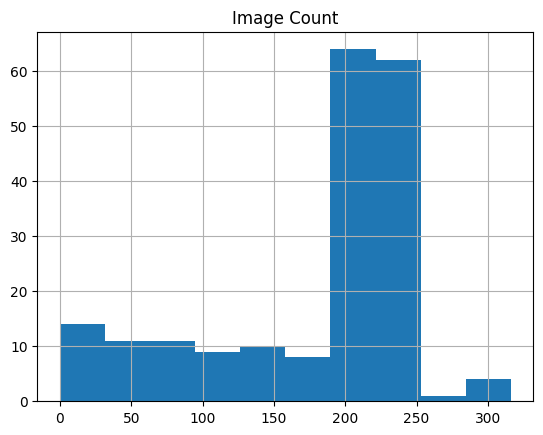

In [4]:
import pandas as pd
import os

l1 = []
l2 = []

for flower in flowers:
    dir_path = os.path.join('images', flower.replace(' ', '_') + '_flower')
    count = 0

    for path in os.listdir(dir_path):

        if os.path.isfile(os.path.join(dir_path, path)):
            if os.path.getsize(os.path.join(dir_path, path)) < 1 * 1024:
                print(os.path.join(dir_path, path), os.path.getsize(os.path.join(dir_path, path)))
                os.remove(os.path.join(dir_path, path))
            else:
                count += 1
    l1.append(flower)
    l2.append(count)

images_df = pd.DataFrame({'Species':l1, 'Image Count':l2})

print(images_df.describe())
tot = sum(images_df['Image Count'])
print(f'Total number of images scraped: {tot}')
images_df.hist()



In [39]:
# Run the object detection filter
# Change the flowers list in flowerfilter.py to extract flowers from specified folders

# !python utils/flowerfilter.py

## Dataset

After running the code above, the flower dataset will be created. You will need to clean the data in order to remove any misclassified images from the dataset. This could occur if one image contains multiple classes of flowers. I Manually removed incorrect images and misidentified objects. Some classes do not have many images uploaded to flickr. Classes with less than 84 images were removed from the dataset. 

       Image Count
count   164.000000
mean    266.219512
std     117.925163
min      84.000000
25%     195.500000
50%     254.000000
75%     304.250000
max     835.000000
Total number of images in Dataset: 43660


array([[<AxesSubplot: title={'center': 'Image Count'}>]], dtype=object)

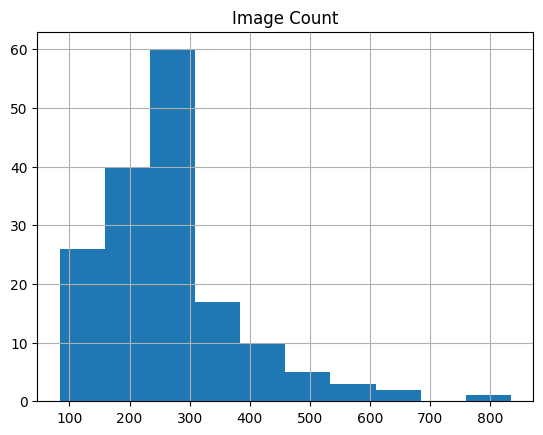

In [15]:

l1 = []
l2 = []

for flower in flowers:
    dir_path = os.path.join('dataset', flower.replace(' ', '_'))
    count = 0
    if not os.path.exists(dir_path):
        continue
    
    for path in os.listdir(dir_path):

        if os.path.isfile(os.path.join(dir_path, path)):
            count += 1
    l1.append(flower)
    l2.append(count)

dataset_df = pd.DataFrame({'Species':l1, 'Image Count':l2})

print(dataset_df.describe())
tot = sum(dataset_df['Image Count'])
print(f'Total number of images in Dataset: {tot}')
dataset_df.hist()

In [16]:
delete = dataset_df[dataset_df['Image Count'] < 84]

delete

,Species,Image Count


In [17]:
import os
import shutil

no_images = list(delete['Species'])

for folder in no_images:    
    unwanted = os.path.join('dataset', folder.replace(' ', '_'))
    if os.path.exists(unwanted) and os.path.isdir(unwanted):
        shutil.rmtree(unwanted)

flowers = os.listdir('dataset')
print(len(flowers))


164
